In [10]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Ridge Regression and SVC machines

Introduce the topic

In [11]:
import numpy as np
import matplotlib.pyplot as plt


## Polynomial Dataset generation

Generate_polynomial_dataset:


In [12]:
def generate_polynomial_dataset(degree: int, n_samples: int):
    x_set = []
    y_set = []
    for i in range(n_samples):
        x = np.random.uniform(-5, 5)
        y = sum(np.random.uniform(0, 1) * (x ** i) for i in range(degree+1)) + np.random.normal(0, 1)
        x_set.append(x)
        y_set.append(y)
    return np.array(x_set), np.array(y_set)

### Example Dataset Generation and Visualisation

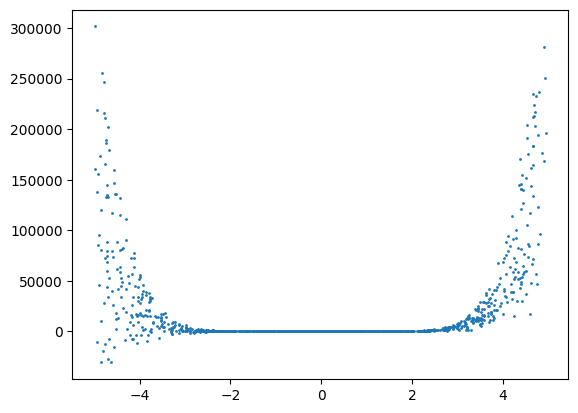

In [13]:
x, y = generate_polynomial_dataset(8, 1000)
plt.scatter(x, y, s=1)

## Ridge Regression

### Closed Form Ridge Regressor


In [14]:
class ClosedFormRidgeRegressor:
    def __init__(self, alpha: float):
        self.alpha = alpha
        self.w = None

    def fit(self, x, y):
        x = np.column_stack((np.ones(x.shape), x))
        # add bias term
        I = np.identity(x.shape[1])
        # bias trick
        I[0, 0] = 0
        #closed form solution
        self.w = np.linalg.inv(x.T @ x + self.alpha * I) @ x.T @ y
        
    def predict(self, x):
        x = np.column_stack((np.ones(x.shape), x))
        return x @ self.w

In [15]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
test_alphas = [0, 0.1, 100]

In [16]:

def get_split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train = x_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)
    return x_train, x_test, y_train, y_test

In [ ]:
def plot_ridge_regression(x, y, alpha):
    x_train, x_test, y_train, y_test = get_split(x,y)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model = ClosedFormRidgeRegressor(alpha=alpha)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    plt.scatter(x_test, y_test, s=1)
    plt.scatter(x_test, y_pred, s=1)
    plt.title(f"Ridge Regression with alpha={alpha}")
    plt.show()

### Linear Dataset regression

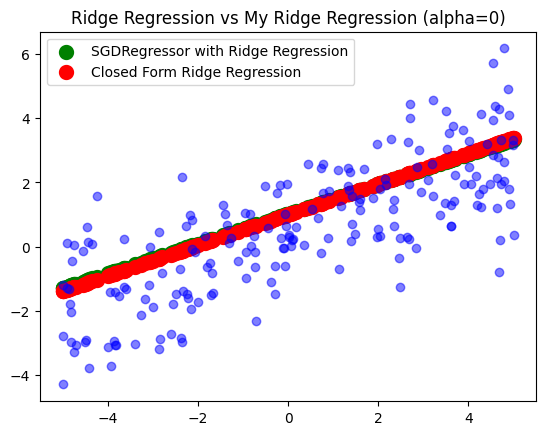

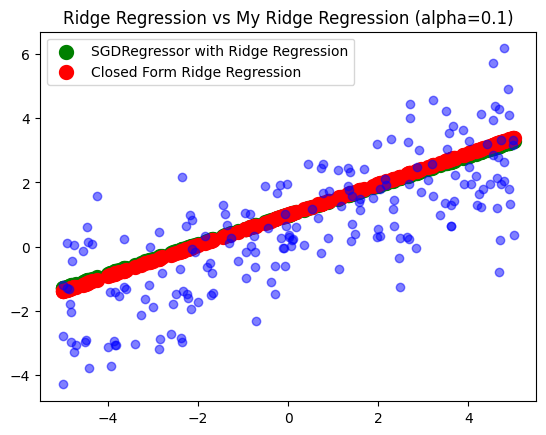

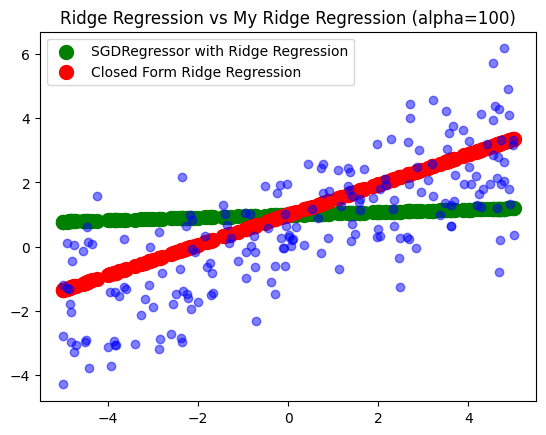

In [80]:
# Linear Datset Testing
np.random.seed(0)
xlin, ylin = generate_polynomial_dataset(1, 1000)
x_train, x_test, y_train, y_test = get_split(xlin, ylin)
for alpha in test_alphas:
        my_ridge = ClosedFormRidgeRegressor(alpha=alpha)
        my_ridge.fit(x_train, y_train)
        my_ridge_pred = my_ridge.predict(x_test)
        my_ridge_pred = my_ridge_pred + my_ridge.w[0]

        ridge = SGDRegressor(penalty='l2', alpha=alpha, max_iter=1000)
        ridge.fit(x_train, y_train)
        ridge_pred = ridge.predict(x_test)
        ridge_pred = ridge_pred + ridge.intercept_


        plt.scatter(x_test, ridge_pred, label='SGDRegressor with Ridge Regression',color='green', linewidth=5)
        plt.scatter(x_test, my_ridge_pred, label='Closed Form Ridge Regression', color='red', linewidth=5)
        plt.scatter(x_test, y_test, color='blue', alpha=0.5)
        plt.title(f"Ridge Regression vs My Ridge Regression (alpha={alpha})")
        plt.legend()
        plt.show()



### Quadratic Dataset Regression

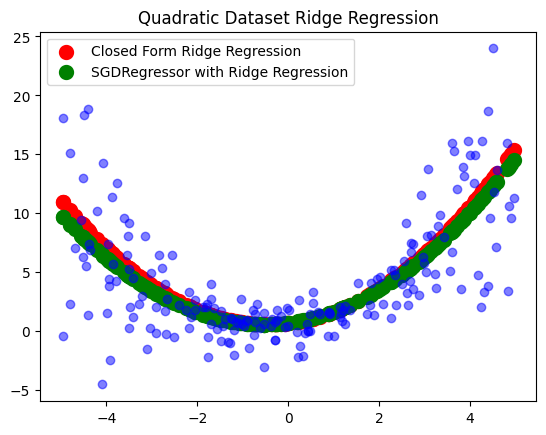

In [ ]:
# Quadratic dataset testing
xquad, yquad = generate_polynomial_dataset(2,1000)
x_train, x_test, y_train, y_test = get_split(xquad, yquad)
x_train_poly = np.column_stack((x_train, x_train**2))
x_test_poly = np.column_stack((x_test, x_test**2))

for alpha in test_alphas:
    # Quadratic dataset testing
    quad_clf = ClosedFormRidgeRegressor(alpha=alpha)
    quad_clf.fit(x_train_poly, y_train)
    quad_pred = quad_clf.predict(x_test_poly)
    quad_pred = quad_pred + quad_clf.w[0]

    quad_sgd = SGDRegressor(penalty='l2', alpha=alpha, max_iter=1000)
    quad_sgd.fit(x_train_poly, y_train)
    quad_sgd_pred = quad_sgd.predict(x_test_poly)
    quad_sgd_pred = quad_sgd_pred + quad_sgd.intercept_


    plt.title("Quadratic Dataset Ridge Regression")
    plt.scatter(x_test, quad_pred, label='Closed Form Ridge Regression', color='red', linewidth=5)
    plt.scatter(x_test, quad_sgd_pred, label='SGDRegressor with Ridge Regression', color='green', linewidth=5)
    plt.legend()
    plt.scatter(x_test, y_test, color='blue', alpha=0.5)

### Cubic Dataset Regression


In [ ]:
# Cubic dataset testing
x_cubic, y_cubic = generate_polynomial_dataset(3,1000)
x_train, x_test, y_train, y_test = get_split(x_cubic,y_cubic)

x_train_poly = np.column_stack((x_train, x_train**2))
x_test_poly = np.column_stack((x_test, x_test**2))
x_train_poly = np.column_stack((x_train_poly, x_train**3))
x_test_poly = np.column_stack((x_test_poly, x_test**3))

x_train_poly = StandardScaler().fit_transform(x_train_poly)
x_test_poly = StandardScaler().fit_transform(x_test_poly)

x_train_poly.shape

(800, 4)

In [90]:

# Quadratic dataset testing
cubic_clf = ClosedFormRidgeRegressor(alpha=alpha)
cubic_clf.fit(x_train_poly, y_train)
cubic_pred = cubic_clf.predict(x_test_poly)
cubic_pred = cubic_pred + cubic_clf.w[0]

cubic_sgd = SGDRegressor(penalty='l2', max_iter=1000,alpha=alpha)
cubic_sgd.fit(x_train_poly, y_train)
sgd_pred = cubic_sgd.predict(x_test_poly)
sgd_pred = sgd_pred + cubic_sgd.intercept_
plt.title("Cubic Dataset Testing")

plt.scatter(x_test, cubic_pred, label='Closed Form Ridge Regression', color='red', linewidth=5)
plt.scatter(x_test, sgd_pred, label='SGDRegressor with Ridge Regression', color='green', linewidth=5)
plt.legend()
plt.scatter(x_test, y_test, color='blue', alpha=0.5)

LinAlgError: Singular matrix

## Support Vector Classifiers

### Dataset

In [ ]:
from sklearn.svm import SVC
import pandas as pd
data = pd.read_csv('wdbc.data', header=None)

# Column 0 is an ID, not needed
# Column 1 is the diagnosis, needed as the label of the classification
# 3 - 12 are mean values
# 13 - 22 are standard error
# 23 - 32 are worst

# Dropping the ID column
data.drop(columns=[0], inplace=True)

# Naming the columns
data.columns = ['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean',
               'smoothness_mean','compactness_mean','concavity_mean','concave_points_mean',
               'symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se',
               'area_se','smoothness_se','compactness_se','concavity_se','concave_points_se',
               'symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst',
               'area_worst','smoothness_worst','compactness_worst','concavity_worst',
               'concave_points_worst','symmetry_worst','fractal_dimension_worst']

#### Dataset Cleaning

In [ ]:
from sklearn.svm import SVC
import pandas as pd


import pandas as pd
data = pd.read_csv('wdbc.data', header=None)
data.head()

# Column 0 is an ID, not needed
# Column 1 is the diagnosis, needed
# 3 - 12 are mean
# 13 - 22 are standard error
# 23 - 32 are worst
data.drop(columns=[0], inplace=True)

# Naming the columns
data.columns = ['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean',
               'smoothness_mean','compactness_mean','concavity_mean','concave_points_mean',
               'symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se',
               'area_se','smoothness_se','compactness_se','concavity_se','concave_points_se',
               'symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst',
               'area_worst','smoothness_worst','compactness_worst','concavity_worst',
               'concave_points_worst','symmetry_worst','fractal_dimension_worst']

labels = data.iloc[:, 0].values

mean_data = data.iloc[:, 2:12].values

stde_data = data.iloc[:, 12:22].values

worst_data = data.iloc[:, 22:32].values

mean_data.shape, stde_data.shape, worst_data.shape
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave_points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

#### Dataset Splitting

### Grid Search and the SVC model

In [ ]:
# Hyperparams to tune
# C
# degree, working with polynomial kernel
# gamma, working with rbf kernel

params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
}

In [ ]:
from sklearn.model_selection import GridSearchCV as GridsearchCV

svc_gs = GridsearchCV(SVC(), params, cv=5, scoring='accuracy',kernel='poly')
svc_gs.fit(mean_data, labels)
svc_gs.best_params_

NameError: name 'SVC' is not defined

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(mean_data, labels, test_size=0.2, random_state=42)
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))




              precision    recall  f1-score   support

           B       0.96      0.94      0.95        71
           M       0.91      0.93      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

[[67  4]
 [ 3 40]]


### Testing the model

### Feasiblity